# Concepts and Practices of Mathematical Finance - Computer Projects

## Vanilla Options in a Black-Scholes world

The purpose of this chapter is to implement the pricing of some vanilla options with the Black-Scholes model for multiple methods. We will be implementing pricing for forwards, puts, calls, digital-puts, digital-calls, and zero-coupon bonds.

First, we need to implement a method for the cumulative-normal function, denoted as $N(x)$:

In [72]:
import math
import numpy as np

#Cumulative normal function, defined by section B.2.2
def N(x):
    
    if x < 0:
        return 1 - N(-x)
    
    k = float(1) / (1 + 0.2316419 * x)
    
    return 1 - (float(1) / math.sqrt(2 * math.pi)) * math.exp(-x**2 / 2) * k * (0.319381530 + k * (-0.356563782 + k * (1.781477937 + k * (-1.821255978 + k * 1.330274429))));

### Forward Pricing

If a liquid asset trades today at $S_0$ with dividend rate $d$ and the continuously compounding rate is $r$ then a forward contract to buy the asset for $K$ with expiry $T$ is worth

\begin{equation}
e^{-rT}(e^{(r-d)T}S_0 - K)
\end{equation}

In particular, the contract will have zero value if and only if

\begin{equation}
K = e^{(r-d)T}S_0
\end{equation}

In [73]:
# Price of a put given spot price (S), dividend rate (d), continuously compounding rate (r), 
# strike price (K) and time to maturity (T)
# Given by Theorem 2.1

class Forward():
    
    def __init__ (self, S, K, d, r, T):
        self.S = S
        self.K = K
        self.d = d
        self.r = r
        self.T = T

    def price(self):
        return math.exp(-self.r * self.T) * (math.exp((self.r - self.d) * self.T) * self.S - self.K)

### Call Pricing

The price of a simple European-style call option, assuming a dividend rate of 0, is given by the Black Scholes formula:

\begin{equation}
C(S,K,\sigma,r,T) = SN(d_1) - Ke^{-rT}N(d_2)
\end{equation}

Where $\sigma$ is the given volatility of the asset price. $d_1$ and $d_2$ are given by the equations:

\begin{equation}
d_1 = \frac{1}{\sigma\sqrt{T}} [ \ln( \frac{S}{K} ) + (r + \frac{\sigma^2}{2})T ]
\end{equation}

\begin{equation}
d_2 = d_1 - \sigma \sqrt{T}
\end{equation}

In [74]:
# Black-Scholes d functions, given by equation 3.26
def d_1(S, K, v, r, T):
    return (1/(v * math.sqrt(T))) * (math.log(S/K) + (r + (v**2 / 2)) * T)

def d_2(S, K, v, r, T):
    return d_1(S,K,v,r,T) - v * math.sqrt(T)

In [83]:
# Master option class from which all others are derived
class Option():
    
    def __init__(self, S, K, v, r, T):
        self.S = S
        self.K = K
        self.v = v # Volatility
        self.r = r
        self.T = T
        
    def price(self):
        raise NotImplementedError("Please implement pricing for this option type")

In [84]:
class Call(Option):
    
    def __init__(self, S, K, v, r, T):
        Option.__init__(self, S, K, v, r, T)
        
    # Black-Scholes formula for European calls, defined by equation 3.25
    def price(self):
        return self.S * N( d_1(self.S, self.K, self.v, self.r, self.T) ) \
    - self.K * math.exp(-self.r * self.T) * N( d_2(self.S, self.K, self.v, self.r, self.T) )

### Put Pricing

There is a similar formula for put options, which can be deduced immediately from the call option formula by using put-call parity:

\begin{equation}
P(S,K,\sigma,r,T) = -SN(-d_1) + Ke^{-rt}N(-d_2)
\end{equation}

In [76]:
class Put(Option):
    
    def __init__(self, S, K, v, r, T):
        Option.__init__(self, S, K, v, r, T)
        
    # Black-Scholes formula for European puts, defined by equation 3.28
    def price(self):
        return -self.S * N( -d_1(self.S, self.K, self.v, self.r, self.T) ) \
            + self.K * math.exp(-self.r * self.T) * N( -d_2(self.S, self.K, self.v, self.r, self.T) ) 

### Forward, Put, Call consistency

We need to make sure that the formulas have been implemented correctly, and pass the following consistency checks.

- We should have put-call parity: the price of a call minus the price of a put equals the value of a forward.
- The price of a call option should be monotone decreasing with strike.
- The price of a call option should be between $S$ and $S - Ke^{-rT}$, for all inputs
- The price of a call option should be increasing in price with volatility
- If $d=0$, the call option price should be increasing with $T$.
- The call option price should be a convex function of strike

In [79]:
# the price of a call minus the price of a put equals the value of a forward
def test_put_call_parity():

    # Example values for inputs
    S = 36.07
    K = 35.0
    v = 0.4825
    r = 0.05
    T = 0.0712

    call_price = Call(S,K,v,r,T).price()
    put_price = Put(S,K,v,r,T).price()
    forward_price = Forward(S,K,0,r,T).price()

    print("Forward Price (F): " + str(forward_price))
    print("Call Price (C): " + str(call_price))
    print("Put Price (P): " + str(put_price))

    print("F - (C - P) = " + str(round(forward_price - (call_price - put_price), 5)))

test_put_call_parity()

Forward Price (F): 1.1943784749543616
Call Price (C): 2.4797369679404966
Put Price (P): 1.285358492986143
F - (C - P) = 0.0


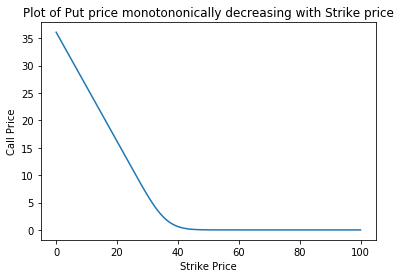

In [80]:
%matplotlib inline
import matplotlib as plt
import seaborn as sns

# The price of a call option should be monotone decreasing (i.e. strictly never increasing) with strike
# Also shows that call option price is a convex function of strike
def test_call_strike_monotone_decrease():

    # Example values for inputs
    S = 36.07
    v = 0.4825
    r = 0.05
    T = 0.0712

    strikes = np.linspace(100,0.001,1000)

    # Calculate array of call prices for each strike value
    call_prices = [1.0] * 1000
    for i in range(len(call_prices)):
        call_prices[i] = Call(S, strikes[i], v, r, T).price()

    strike_plot = sns.lineplot(strikes, call_prices)
    strike_plot.set(xlabel = 'Strike Price', ylabel = 'Call Price', 
             title='Plot of Put price monotononically decreasing with Strike price')
    
test_call_strike_monotone_decrease()

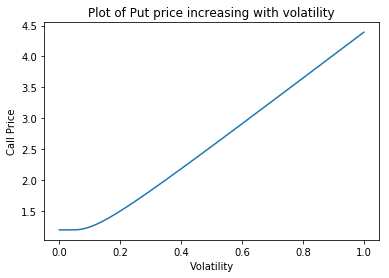

In [81]:
# The price of a call option should be monotone decreasing (i.e. strictly never increasing) with strike
def test_call_volatility_price_increase():

    # Example values for inputs
    S = 36.07
    K = 35.0
    r = 0.05
    T = 0.0712

    volatilities = np.linspace(0.001,1,1000)

    # Calculate array of call prices for each strike value
    call_prices = [1.0] * 1000
    for i in range(len(call_prices)):
        call_prices[i] = Call(S, K, volatilities[i], r, T).price()

    volatility_plot = sns.lineplot(volatilities, call_prices)
    volatility_plot.set(xlabel = 'Volatility', ylabel = 'Call Price', 
             title='Plot of Put price increasing with volatility')
    
test_call_volatility_price_increase()

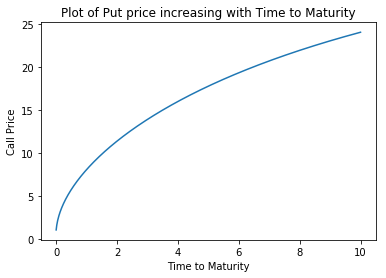

In [82]:
# If 𝑑=0, the call option price should be increasing with 𝑇 .
def test_call_time_to_maturity_price_increase():

    # Example values for inputs
    S = 36.07
    K = 35.0
    v = 0.4825
    r = 0.05

    time_to_maturity = np.linspace(0.001,10,1000)

    # Calculate array of call prices for each strike value
    call_prices = [1.0] * 1000
    for i in range(len(call_prices)):
        call_prices[i] = Call(S, K, v, r, time_to_maturity[i]).price()

    volatility_plot = sns.lineplot(time_to_maturity, call_prices)
    volatility_plot.set(xlabel = 'Time to Maturity', ylabel = 'Call Price', 
             title='Plot of Put price increasing with Time to Maturity')
    
test_call_time_to_maturity_price_increase()

### Digital Puts and Calls, Zero-Coupon Bonds

The price of a digital call is given by:

\begin{equation}
e^{-rT}N(d_2)
\end{equation}

As the price of a digital call plus a digital put is a zero-coupon bond, we conclude that the price of a digital put is given by:

\begin{equation}
e^{-rT}(1-N(d_2)) = e^{-rT}N(-d_2)
\end{equation}

In [85]:
# Price of a digital call
def DC(S, K, v, r, T):
    return math.exp(-r * T) * N( d_2(S, K, v, r, T))

class DigitalCall(Option):
    
    def __init__(self, S, K, v, r, T):
        Option.__init__(self, S, K, v, r, T)
        
    def price(self):
        return math.exp(-self.r * self.T) * N( d_2(self.S, self.K, self.v, self.r, self.T))

In [86]:
class DigitalPut(Option):
    
    def __init__(self, S, K, v, r, T):
        Option.__init__(self, S, K, v, r, T)
        
    def price(self):
        return math.exp(-self.r * self.T) * N( -d_2(self.S, self.K, self.v, self.r, self.T))

The price of a Zero-Coupon bond is given by:

\begin{equation}
ZC(K,r,T) = \frac{1}{e^{rT}}
\end{equation}

In [87]:
# Price of a ZC Bond
def ZC(K, r, T):
    return 1 / math.exp(r * T)

class ZeroCouponBond():
    
    def __init__(self, K, r, T):
        self.K = K
        self.r = r
        self.T = T
        
    def price(self):
        return 1 / math.exp(self.r * self.T)

### Digital Puts and Calls, Zero-Coupon Bonds Consistency

- The price of a call-spread should approximate the price of a digital-call option.
- The price of a digital-call option plus a digital-put option is equal to the price of a zero-coupon bond.

In [88]:
def call_spread_equals_digital_call():
    
    # Example values for inputs
    S = 36.07
    K = 37.0
    v = 0.4825
    r = 0.05
    T = 0.0712
    
    digital_call_price = DigitalCall(S,K,v,r,T).price()
    
    # Digital call option can be recreated with two call options of different strike price
    K_1 = 38.121 # This strike price could be graphed to find the closest value such that the spread models a DC perfectly
    
    call_1 = Call(S,K,v,r,T).price()
    call_2 = Call(S,K_1,v,r,T).price()
    
    print("Digital Call Price (DC): " + str(digital_call_price))
    print("Call 1 Price (C_1): " + str(call_1))
    print("Call 2 Price (C_1): " + str(call_2))
    
    print("Price of a digital call should approximate longing a call and shorting another with slightly higher strike price.")
    print("DC - (C_1 - C_2) = " + str(round(digital_call_price - (call_1 - call_2), 5)))
    
call_spread_equals_digital_call()

Digital Call Price (DC): 0.40587167747125863
Call 1 Price (C_1): 1.4995719248050339
Call 2 Price (C_1): 1.0939759779544254
Price of a digital call should approximate longing a call and shorting another with slightly higher strike price.
DC - (C_1 - C_2) = 0.00028


In [89]:
def zero_coupon_digital_put_call_parity():
    
    # Example values for inputs
    S = 36.07
    K = 35.0
    v = 0.4825
    r = 0.05
    T = 0.0712
    
    digital_call_price = DC(S,K,v,r,T)
    digital_put_price = DP(S,K,v,r,T)
    zc_bond_price = ZC(K, r, T)

    print("Zero-Coupon Bond Price (ZC): " + str(zc_bond_price))
    print("Digital Call Price (DC): " + str(digital_call_price))
    print("Digital Put Price (DP): " + str(digital_put_price))

    print("ZC - (DC + DP) = " + str(round(zc_bond_price - (digital_call_price + digital_put_price), 5)))

zero_coupon_digital_put_call_parity()   

Zero-Coupon Bond Price (ZC): 0.9964463292870183
Digital Call Price (DC): 0.5760995966071634
Digital Put Price (DP): 0.420346732679855
ZC - (DC + DP) = -0.0


## Validation via Monte Carlo

We want to test the prices against a Monte Carlo simulation, using a random number generator that can be changed at any time to check for bias. From this, we can first implement an engine that randomly evolves a stock price from time 0 to time $T$ according to a geometric Brownian motion with drift $r-d$ and volatility $\sigma$, using the formula:

\begin{equation}
S_T = S_0 e^{(r-d)T} - \frac{1}{2} \sigma^2 T + \sigma \sqrt{T} W
\end{equation}

where $W$ is a standard random variable.

In [90]:
import random as rand # Using the standard Python random number library, can be replaced

def S_T(S_0, r, d, T, v):
    
    W = rand.random() #Produces a value between 0.0 and 1.0
    
    first_term = S_0 * math.exp((r-d)*T)
    second_term = 0.5 * v**2 * T
    third_term = v * math.sqrt(T) * W
    
    return first_term - second_term + third_term

We can then use this engine to write Monte Carlo pricers for all the products mentioned above, and produce a final stock value.